# 1. Libaries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, precision_recall_curve, f1_score
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score

from models.EFM import Ethereum_Fraud_Model
from models.RF import Random_Forest_Model
from models.DBSCAN import DBSCAN_Model
from models.SVM import SVM_Model
from models.LR import Logistic_Regression_Model
from models.GMM import GMM_Model
from models.PCA import PCA_Transformer

from config import *
from utils.cleaner import *

# 2. Data Reading

In [2]:
efm = Ethereum_Fraud_Model()
print(efm.df.shape)
display(efm.df.head())

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
1062,1063,0x1afc9fdc5a560f2973ade0faf35793f26cc05cf1,0,0.00,29587.85,118351.40,0,4,1,2,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7903,242,0x1a8479634ba4f57533b48719f9d2b20c5fcdfa9d,1,107.20,28.66,271.72,2,2,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5278,2346,0x8c058578593b27c199f6877dad94eb182b82b79f,0,165.55,0.82,332.73,2,2,0,2,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2274,2275,0x3b562b660863eb2efe71009cf4318469ec7ce29b,0,160.91,0.84,323.50,2,2,0,2,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0
7206,4274,0xc140ed418b1c4adbc2919d5bc1ace49c9f65ba26,0,182.96,60.47,1055315.08,5766,6,0,3,...,0.0,0.000001,0.0,0.0,0.0,0.0,1.0,24.0,DGD,DGD


# 3. Data Exploration

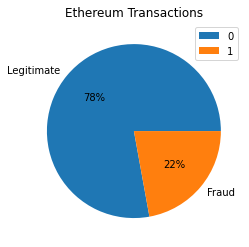

In [3]:
df = efm.df.copy()
flag_counts = df['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

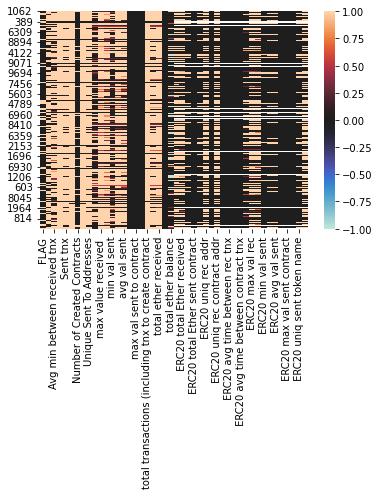

In [4]:
df.drop(efm.filtered_colns, axis=1, inplace=True)
ax = sns.heatmap(df, center=0, vmin=-1, vmax=1)

['total ether sent contracts', ' ERC20 max val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq rec token name']


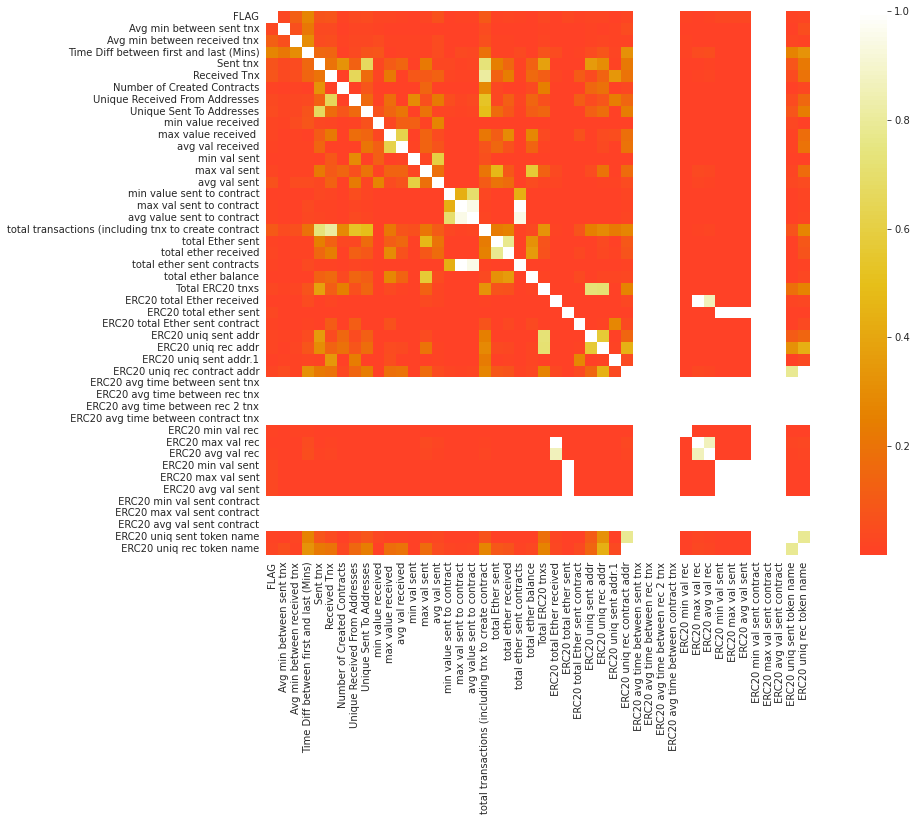

In [5]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr_matrix, annot=False, cmap='CMRmap', center=0, square=True)

# Find features with correlation greater than 0.95
corr_colns = [column for column in upper.columns if any(upper[column] > 0.95)]

print(corr_colns)
df.drop(corr_colns, axis=1, inplace=True)

# Add Box Plot Analysis

# 4. Data Cleaning

In [6]:
print_nan_data(df)

FLAG                                                    0.000000
Avg min between sent tnx                                0.000000
Avg min between received tnx                            0.000000
Time Diff between first and last (Mins)                 0.000000
Sent tnx                                                0.000000
Received Tnx                                            0.000000
Number of Created Contracts                             0.000000
Unique Received From Addresses                          0.000000
Unique Sent To Addresses                                0.000000
min value received                                      0.000000
max value received                                      0.000000
avg val received                                        0.000000
min val sent                                            0.000000
max val sent                                            0.000000
avg val sent                                            0.000000
min value sent to contrac

In [7]:
# Drop missing data observations/rows
df_clean = remove_nan_rows(df)
print_nan_data(df_clean)

FLAG                                                    0.0
Avg min between sent tnx                                0.0
Avg min between received tnx                            0.0
Time Diff between first and last (Mins)                 0.0
Sent tnx                                                0.0
Received Tnx                                            0.0
Number of Created Contracts                             0.0
Unique Received From Addresses                          0.0
Unique Sent To Addresses                                0.0
min value received                                      0.0
max value received                                      0.0
avg val received                                        0.0
min val sent                                            0.0
max val sent                                            0.0
avg val sent                                            0.0
min value sent to contract                              0.0
max val sent to contract                

In [8]:
# Drop missing data features/columns
# df_clean = remove_nan_columns(df)

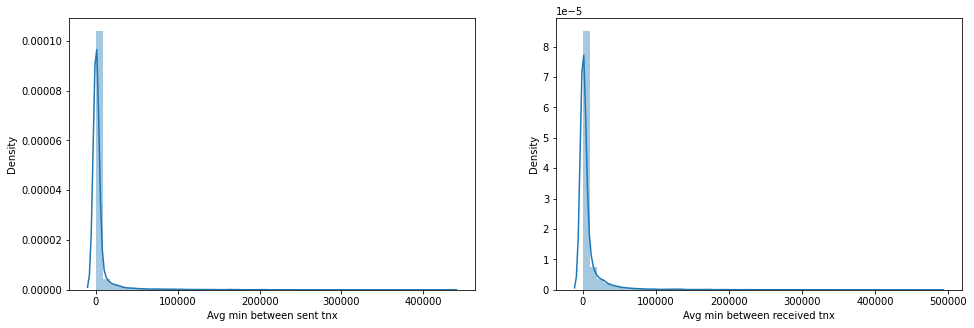

In [9]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['Avg min between sent tnx'])
plt.subplot(1,2,2)
sns.distplot(df['Avg min between received tnx'])
plt.show()

<AxesSubplot:xlabel='Avg min between received tnx'>

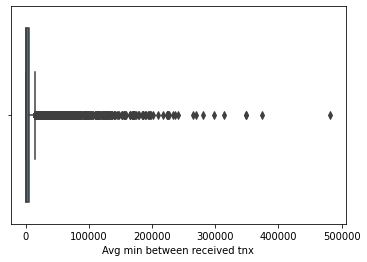

In [10]:
sns.boxplot(df['Avg min between received tnx'])

In [11]:
percentile25 = df['Avg min between received tnx'].quantile(0.25)
percentile75 = df['Avg min between received tnx'].quantile(0.75)

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

df[df['Avg min between received tnx'] > upper_limit]
df[df['Avg min between received tnx'] < lower_limit]

NameError: name 'iqr' is not defined

# 5. Data Preparation

In [12]:
# Normalizae Data
df_norm = df_clean.copy()

# apply normalization techniques
for column in df_norm.columns:
    if column == TARGET:
        continue
    print(column, df_norm[column].max(), df_norm[column].min(), (df_norm[column].max() - df_norm[column].min()))
    df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())

df_norm.dropna(inplace=True, axis=1)
print(df_norm)

Avg min between sent tnx 430287.67 0.0 430287.67
Avg min between received tnx 482175.49 0.0 482175.49
Time Diff between first and last (Mins) 1954860.95 0.0 1954860.95
Sent tnx 10000 0 10000
Received Tnx 10000 0 10000
Number of Created Contracts 9995 0 9995
Unique Received From Addresses 9999 0 9999
Unique Sent To Addresses 9287 0 9287
min value received 10000.0 0.0 10000.0
max value received  800000.0 0.0 800000.0
avg val received 283618.8316 0.0 283618.8316
min val sent 12000.0 0.0 12000.0
max val sent 520000.0 0.0 520000.0
avg val sent 12000.0 0.0 12000.0
min value sent to contract 0.02 0.0 0.02
max val sent to contract 0.046029 0.0 0.046029
avg value sent to contract 0.023014 0.0 0.023014
total transactions (including tnx to create contract 19995 0 19995
total Ether sent 28580960.89 0.0 28580960.89
total ether received 28581590.07 0.0 28581590.07
total ether balance 14288636.26 -15605352.04 29893988.299999997
 Total ERC20 tnxs 10001.0 0.0 10001.0
 ERC20 total Ether received 1000020

In [21]:
display(df_norm)

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name
1567,0,0.000000,0.000000,0.000089,0.0001,0.0001,0.0000,0.0001,0.000108,1.741730e-05,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000
4208,0,0.000000,0.000000,0.000048,0.0001,0.0001,0.0000,0.0001,0.000108,1.075030e-04,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000
1662,0,0.000000,0.005963,0.107378,0.0000,0.0073,0.0001,0.0004,0.000000,0.000000e+00,...,2.069683e-12,0.000000e+00,0.0,0.000000,0.000699,0.0,0.003836,3.205010e-07,4.001366e-11,0.000000
7130,0,0.000000,0.000000,0.013670,0.0001,0.0001,0.0000,0.0001,0.000108,5.095000e-04,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000
4039,0,0.000000,0.000000,0.000022,0.0001,0.0001,0.0000,0.0001,0.000108,1.061700e-04,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8175,1,0.000106,0.000960,0.000874,0.0007,0.0003,0.0000,0.0002,0.000754,1.000000e-04,...,2.499950e-11,0.000000e+00,0.0,0.000000,0.000233,0.0,0.001279,2.525253e-05,1.449964e-09,0.000000
6264,0,0.000009,0.021935,0.032472,0.0005,0.0006,0.0000,0.0002,0.000538,5.590000e-08,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000
1509,0,0.000000,0.000000,0.000287,0.0001,0.0001,0.0000,0.0001,0.000108,6.000000e-06,...,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000
9118,1,0.001137,0.001098,0.001563,0.0003,0.0003,0.0000,0.0002,0.000323,4.005000e-07,...,9.899802e-11,0.000000e+00,0.0,0.000000,0.000466,0.0,0.002558,0.000000e+00,2.870928e-09,0.000000


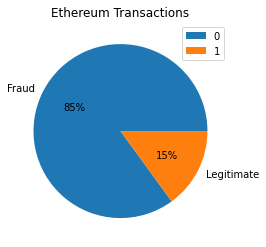

In [22]:
flag_counts = df_norm['FLAG'].value_counts()

plt.pie(flag_counts, labels={'Fraud', 'Legitimate'}, autopct='%.0f%%')
plt.title('Ethereum Transactions')
plt.legend(flag_counts.keys().tolist())
plt.show()

# 6. Sampling

## Method 1. SMOTE Sampling

In [15]:
from utils.sampling import smote

df_smote = df_norm.copy()

X = df_smote.drop(TARGET, axis=1)
y = df_smote[TARGET]
X_res, y_res = smote(X, y, verbose=True)
df_smote = pd.concat([X_res, y_res], axis=1)
display(df_smote.head())

Original Data Distribution:  Counter({0: 7662, 1: 1350})
Data Distribution After SMOTE:  Counter({0: 7662, 1: 7662})


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name,FLAG
0,0.0,0.000000,0.000089,0.0001,0.0001,0.0000,0.0001,0.000108,0.000017,2.177162e-07,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0
1,0.0,0.000000,0.000048,0.0001,0.0001,0.0000,0.0001,0.000108,0.000108,1.343787e-06,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0
2,0.0,0.005963,0.107378,0.0000,0.0073,0.0001,0.0004,0.000000,0.000000,1.491850e-07,...,0.0,0.0,0.0,0.000699,0.0,0.003836,3.205010e-07,4.001366e-11,0.0,0
3,0.0,0.000000,0.013670,0.0001,0.0001,0.0000,0.0001,0.000108,0.000509,6.368750e-06,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0
4,0.0,0.000000,0.000022,0.0001,0.0001,0.0000,0.0001,0.000108,0.000106,1.327125e-06,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0


## Method 2. 3-Way cross validation

# 7. Modeling

## Model 1. Supervised: Random Forest

Highest Accuracy At Depth:  94


1it [00:01,  1.72s/it]

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99      2576
       fraud       0.94      0.97      0.95       489

    accuracy                           0.99      3065
   macro avg       0.97      0.98      0.97      3065
weighted avg       0.99      0.99      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [2544   32   13  476]


2it [00:03,  1.77s/it]

              precision    recall  f1-score   support

      normal       1.00      0.98      0.99      2628
       fraud       0.92      0.99      0.95       437

    accuracy                           0.98      3065
   macro avg       0.96      0.99      0.97      3065
weighted avg       0.99      0.98      0.99      3065

Confusion Matrix: [tn, fp, fn, tp] =  [2588   40    6  431]


3it [00:05,  1.78s/it]

              precision    recall  f1-score   support

      normal       0.99      0.98      0.99      2458
       fraud       0.94      0.98      0.96       607

    accuracy                           0.98      3065
   macro avg       0.97      0.98      0.97      3065
weighted avg       0.98      0.98      0.98      3065

Confusion Matrix: [tn, fp, fn, tp] =  [2419   39   14  593]


4it [00:06,  1.63s/it]

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         0
       fraud       1.00      0.99      1.00      3065

    accuracy                           0.99      3065
   macro avg       0.50      0.50      0.50      3065
weighted avg       1.00      0.99      1.00      3065

Confusion Matrix: [tn, fp, fn, tp] =  [   0    0   28 3037]


5it [00:08,  1.63s/it]

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         0
       fraud       1.00      0.99      1.00      3064

    accuracy                           0.99      3064
   macro avg       0.50      0.50      0.50      3064
weighted avg       1.00      0.99      1.00      3064

Confusion Matrix: [tn, fp, fn, tp] =  [   0    0   20 3044]


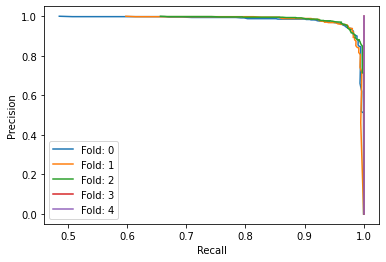

In [22]:
df_rfm = df_smote.copy()
rfm = Random_Forest_Model(df_rfm)
rfm.set_max_depth(100)
efm.add_model(rfm)
efm.run_model(model_name='RandomForest')

## Model 2. Supervised: Logistic Regression

Model Name:  Logistic Regression
Accuracy Score:  0.6825448613376836
AUPRC: 0.7512664472346549
F1 score:  0.7245966600622701 

Accuracy Score:  0.6861337683523654
AUPRC: 0.7488922670209315
F1 score:  0.7365826944140198 

Accuracy Score:  0.6893964110929853
AUPRC: 0.7352823085604334
F1 score:  0.7346711259754738 

Accuracy Score:  0.6734094616639478
AUPRC: 0.7335793937908783
F1 score:  0.7238620689655172 

Accuracy Score:  0.6866840731070496
AUPRC: 0.754732611624159
F1 score:  0.7371303395399781 



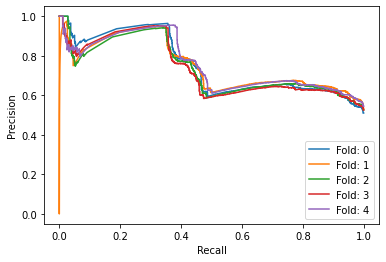

Token Counts f1 score lbfgs:  0.7313685777914518


In [21]:
df_lr = df_smote.copy()
df_lr = shuffle(df_lr)
lr = Logistic_Regression_Model(df_lr)
lr.run()

## Model 3. Supervised: Support Vector Machine (SVM)

Model Name:  SVM
Accuracy: 0.7057096247960848
F1 score: 0.7437499999999999
AUPRC: 0.8179327102715159
Accuracy: 0.7265905383360522
F1 score: 0.7659217877094973
AUPRC: 0.8366505007510886
Accuracy: 0.7187601957585644
F1 score: 0.7556689342403629
AUPRC: 0.8241805572610958
Accuracy: 0.7239804241435562
F1 score: 0.7678375411635564
AUPRC: 0.8603511381544683
Accuracy: 0.7287859007832899
F1 score: 0.7730128380223983
AUPRC: 0.8359340866968384


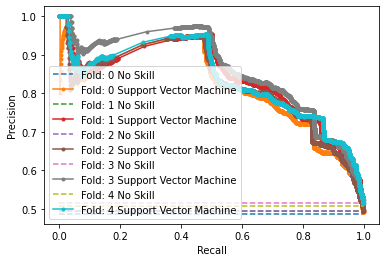

Token Counts f1 score lbfgs:  0.7612382202271629


'\'df_svm = shuffle(df_svm)\nX = df_svm.drop(columns=[TARGET_FEATURE], axis=1)\ny = df_svm[TARGET_FEATURE]\n\nfor count, (train, test) in enumerate(kfold(X, y, 5)):\n    X_train, X_test = X.iloc[train], X.iloc[test]\n    y_train, y_test = y.iloc[train], y.iloc[test]\n    clf = svm.SVC(probability = True)\n    clf.fit(X_train,y_train)\n    y_pred = clf.predict_proba(X_test)\n    y_hat = clf.predict(X_test)\n    # Model Accuracy, how often is the classifier correct?\n    print("Accuracy:", accuracy_score(y_test, y_hat))\n    print("F1 score:", f1_score(y_test, y_hat))\n    fraud_precision, fraud_recall, thresholds = precision_recall_curve(y_test, y_pred[:, 1])\n    print("AUPRC:", auc(fraud_recall, fraud_precision))\n    # plot the precision-recall curves\n    no_skill = len(y_test[y_test==1]) / len(y_test)\n    label = \'Fold: \'+ str(count)\n    plt.plot([0, 1], [no_skill, no_skill], linestyle=\'--\', label=label+\' No Skill\')\n    plt.plot(fraud_recall, fraud_precision, marker=\'.\',

In [31]:
from sklearn import svm

df_svm = df_smote.copy()
svm_model = SVM_Model(df_svm)
svm_model.run()

## Model 3. Unsupervised: GMM

(9012, 33)
(9012, 33)
-0.5317929299794691
2.6542123635083668


"\nprint(gmm_df[feature1].mean())\nprint(gmm_df[feature1].std())\n\nax[0,0].hist(gmm_df[feature1], bins=100)\nax[0,0].set_title(feature1, fontsize=14)\nax[0,0].set_ylabel('Transactions')\n\nax[0,1].hist(gmm_df[feature2], bins=100)\nax[0,1].set_title(feature2, fontsize=14)\nax[0,1].set_ylabel('Transactions')\n\nax[1,0].hist(gmm_df[feature3], bins=100)\nax[1,0].set_title(feature3, fontsize=14)\nax[1,0].set_ylabel('Transactions')\n\nax[1,1].hist(gmm_df[feature4], bins=100)\nax[1,1].set_title(feature4, fontsize=14)\nax[1,1].set_ylabel('Transactions')\n"

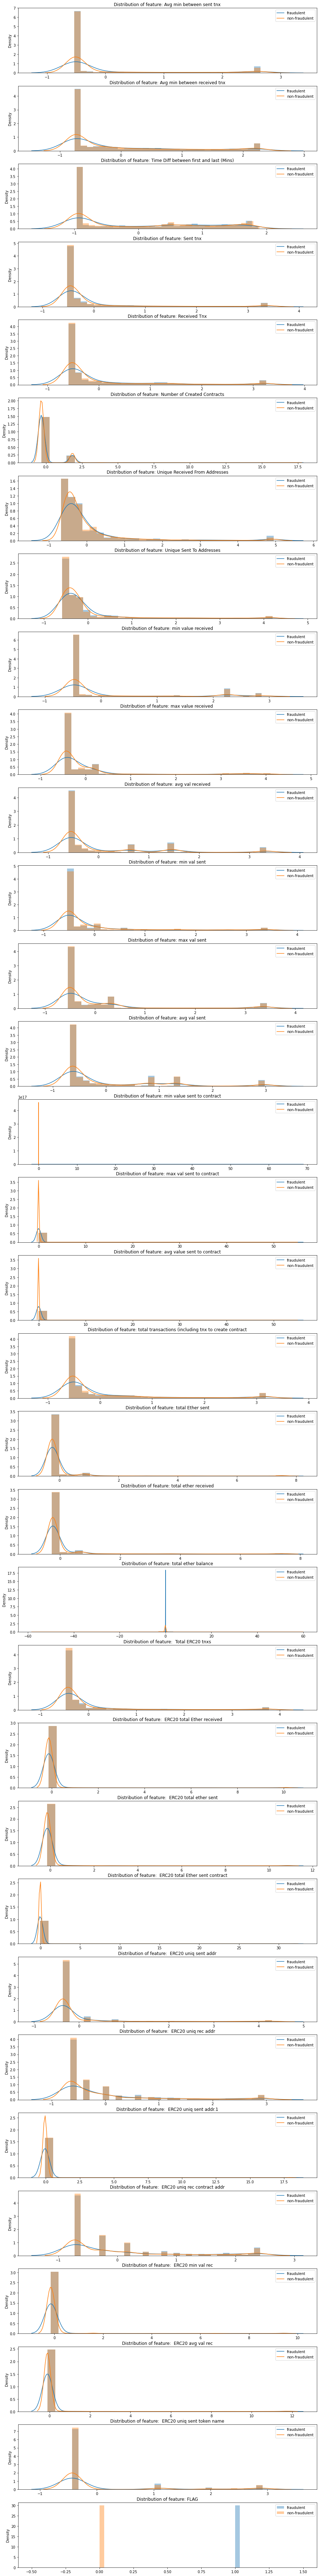

In [15]:
# Trying Standardizing data to get better result with 

from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import PowerTransformer

gmm_df = df_norm.copy().drop(TARGET, axis=1)
gmm_features = gmm_df.columns

# Standardization
# scale= StandardScaler()
# gmm_df = pd.DataFrame(scale.fit_transform(gmm_df), columns=gmm_df.columns)
# gmm_df[TARGET] = df_norm[TARGET]

# print(df_norm.shape)
# print(gmm_df.shape)

# Transform
powerTran = PowerTransformer(method="yeo-johnson")
gmm_df = powerTran.fit_transform(gmm_df)
gmm_df = pd.DataFrame(gmm_df, columns=gmm_features)
gmm_df[TARGET] = df_norm[TARGET] 

print(df_norm.shape)
print(gmm_df.shape)

# Draw
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

# features = ['Avg min between sent tnx', 'Avg min between received tnx', 'Sent tnx', 'Received Tnx']
# features = gmm_df.columns

# nplots=np.size(features)
# plt.figure(figsize=(15,4*nplots))
# gs = gridspec.GridSpec(nplots,1)
# for i, feat in enumerate(features):
#     ax = plt.subplot(gs[i])
#     sns.distplot(gmm_df[feat][df.FLAG==1], bins=30)
#     sns.distplot(gmm_df[feat][df.FLAG==0],bins=30)
#     ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
#     ax.set_xlabel('')
#     ax.set_title('Distribution of feature: ' + feat)

# print(gmm_df['Avg min between sent tnx'].min())
# print(gmm_df['Avg min between sent tnx'].max())

'''
print(gmm_df[feature1].mean())
print(gmm_df[feature1].std())

ax[0,0].hist(gmm_df[feature1], bins=100)
ax[0,0].set_title(feature1, fontsize=14)
ax[0,0].set_ylabel('Transactions')

ax[0,1].hist(gmm_df[feature2], bins=100)
ax[0,1].set_title(feature2, fontsize=14)
ax[0,1].set_ylabel('Transactions')

ax[1,0].hist(gmm_df[feature3], bins=100)
ax[1,0].set_title(feature3, fontsize=14)
ax[1,0].set_ylabel('Transactions')

ax[1,1].hist(gmm_df[feature4], bins=100)
ax[1,1].set_title(feature4, fontsize=14)
ax[1,1].set_ylabel('Transactions')
'''

In [14]:


# GMM
# df_gmm = df_smote.copy()
gmm_model = GMM_Model(gmm_df)
gmm_model.run(verbose=True)
# efm.add_model(gmm_model)
# efm.run_model(model_name='GMM', verbose=True)

Model Name: GMM


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,...,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 avg val rec,ERC20 uniq sent token name,FLAG
0,-0.531793,2.094861,-0.051626,-0.518305,-0.508159,1.839776,-0.403589,-0.585664,-0.254811,-0.175584,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0
1,-0.447621,-0.761016,-0.956044,-0.461708,-0.546840,-0.319282,-0.403589,-0.323294,-0.266222,0.131955,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0
2,-0.449949,-0.761010,-0.956131,-0.461708,-0.546840,-0.319282,-0.403589,-0.323294,1.389503,-0.135897,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0
3,-0.438902,-0.743496,1.743832,3.387629,-0.469880,-0.319282,-0.272815,4.198136,-0.490666,-0.436341,...,-0.139037,-0.033691,4.297757,2.967423,-0.055827,2.357198,-0.154134,0.829683,1.106962,0.0
4,-0.531793,-0.451342,-0.920069,-0.489902,-0.546840,-0.319282,-0.403589,-0.452624,-0.424852,-0.456467,...,-0.139037,-0.033691,-0.359114,-0.652910,-0.055827,-0.727219,-0.154134,-0.110482,-0.433548,0.0


Components: 1
GMM Score for train set
-22.336911093543854
GMM Score for normal transcation subset in validation set
-21.370567655345116
GMM Score for fraud transcation subset in validation set
-31.548860407971322
0.506344410876133 99
The final threshold selected is:  0.0
Final threshold: 0.000000
Test Recall Score: 1.000
Test Precision Score: 0.339
Test F1 Score: 0.506
tn, fp, fn, tp: [  0 818   0 419]
Components: 2
GMM Score for train set
38.19756356482751
GMM Score for normal transcation subset in validation set
41.10082353017954
GMM Score for fraud transcation subset in validation set
36.12380595416609
0.2682926829268293 96
The final threshold selected is:  -24.24242424242425
Final threshold: -24.242424
Test Recall Score: 0.210
Test Precision Score: 0.406
Test F1 Score: 0.277
tn, fp, fn, tp: [689 129 331  88]
Components: 3
GMM Score for train set
58.147956360290664
GMM Score for normal transcation subset in validation set
61.9366283015268
GMM Score for fraud transcation subset in va

## Model 4. Unsupervised: DBSCAN

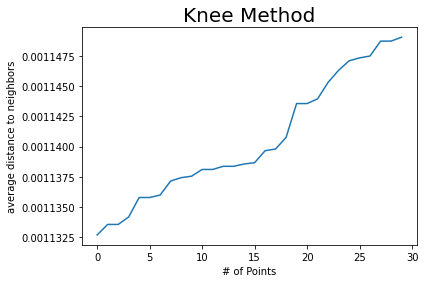

EPS 0.0011381001685537542
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.0011381001685537542
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.001138361974542792
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.001138361974542792
Estimated number of clusters: 214
Estimated number of Noise Points: 6662
EPS 0.001138553570403505
Estimated number of clusters: 214
Estimated number of Noise Points: 6659
EPS 0.0011386614708195563
Estimated number of clusters: 215
Estimated number of Noise Points: 6655
EPS 0.0011396568707737976
Estimated number of clusters: 215
Estimated number of Noise Points: 6653
EPS 0.0011398002116178982
Estimated number of clusters: 215
Estimated number of Noise Points: 6653
EPS 0.0011407605186887926
Estimated number of clusters: 215
Estimated number of Noise Points: 6653
EPS 0.001143575009746082
Estimated number of clusters: 215
Estimated number of Noise Points: 6652
EPS 0.00114357

In [26]:
# DBSCAN Model
df_dbscan = df_smote.copy()
dbscan_model = DBSCAN_Model(df_dbscan)
efm.add_model(dbscan_model)
efm.run_model(model_name='DBSCAN')

# 8. Model Evaluation (by Kenny)

### -------------------- Functions Delarations --------------------

In [ ]:
# Helper: compute corresponding f1-score given thresholds
def compute_f1(y_test, y_pred, thresholds):
    scores = []
    for th in thresholds:
        th_y_pred = y_pred.copy()
        
        th_y_pred[th_y_pred >= th] = 0
        th_y_pred[th_y_pred < th] = 1
        scores.append(f1_score(y_test, th_y_pred))
    return scores


def plot_ROC(y_test, y_pred, plt_config, f1=False):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('ROC for ' + plt_config['model'])
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.plot([0,1], [0,1], 'y--')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('True Positive Rate / Score')
    plt.xlabel('False Positive Rate / Threshold')
    plt.legend(['ROC', 'Perfect Classifier', 'F1'])
    plt.show()


def plot_PRC(y_test, y_pred, plt_config, f1=False):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    scores = []
    if f1:
        scores = compute_f1(y_test, y_pred, thresholds)

    plt.figure(figsize=plt_config['figsize'])
    plt.title('PRC for ' + plt_config['model'])
    plt.plot(recall, precision, 'b')
    if f1:
        plt.plot(thresholds, scores, 'r')
    plt.ylabel('Precision / Score')
    plt.xlabel('Recall / Threshold')
    plt.legend(['PRC', 'F1'])
    plt.show()


## Metric 1. ROC w/ F1

In [ ]:
# Prepare parameters for ROC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_ROC(y_test, pred, plt_config, f1=True)
"""

## Metric 2. PRC w/ F1

In [ ]:
# Prepare parameters for PRC

# Uncomment the following when you have data ready

"""
# Get probablistic predictions using a trained model
probs = xgb_c.predict_proba(norm_test_f)
pred = probs[:, 1]

# Customize plot
plt_config = {
    'figsize': (12, 8),
    'model': 'XGB Classifier'
}

# Call the function with your choice of f1 plotting (in the same grapgh)
plot_PRC(y_test, pred, plt_config, f1=True)
"""